# Running Simple Analysis

1. Simulate source and SEEG signals using TVB

2. Analyze the power spectrum using variety of methods:
    - PSD using multitaper,  welch's method
    - Windowed PSD using multittaper wavelet, short-time FFT, morlet, stockwell transforms
    - old transform methods that we coded by hand (multitaper FFT, morlet wavelet)

3. Note: Stockwell analysis takes significant amount of time vs the other methods.

To Analyze:
1. How do the mne based methods compare with the old transform methods we have here?
2. If they are the same, should we stick with the mne methods for robust methods that are open source kept?
3. If they are different, what are the differences, should we switch?

### References:
1. https://www.martinos.org/mne/stable/python_reference.html?highlight=time_frequency#module-mne.time_frequency


In [45]:
import numpy as np
import pandas as pd
import os
import sys
import mne
np.random.seed(123456789)
sys.path.append('../../../')
from tvb.simulator.lab import *
import tvbsim

# to run simulation and post processing and data loading
from tvbsim.postprocess.postprocess import PostProcessor
from tvbsim.postprocess.detectonsetoffset import DetectShift
from tvbsim.maintvbexp import MainTVBSim
from tvbsim.io.patient.subject import Subject
from tvbsim.io.simdata.loadtvbdata import StructuralDataLoader
from tvbsim.io.loadsimdataset import LoadSimDataset
from tvbsim.base.constants.config import Config

from tvbsim.visualize.old import plotts
sys.path.append('../../../bintng/util/')
from run_freq import FreqAnalysis
from tvbsim.execute.cluster.hpc_tvbsimmodel import SimVsRealModel
from tvbsim.execute.cluster.hpc_tvbsimmodel import TVBSimModel

# import basic plotting
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# configuration and plotting
config = Config() 
config.figures.MATPLOTLIB_BACKEND="qt5" #"Qt4Agg" #"inline"
config.figures.SHOW_FLAG=True

import logging
logger = logging.getLogger()
logger.setLevel(logging.ERROR)

# Import magic commands for jupyter notebook 
# - autoreloading a module
# - profiling functions for memory usage and scripts
%load_ext line_profiler
%load_ext memory_profiler
%matplotlib inline
%load_ext autoreload
%autoreload 2

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler
The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Simulate Basic Model With 20 seconds

- tt = 1
- perform fft analysis

In [46]:
from tvbsim.exp.master import MasterExp

patient = 'id001_bt'
root_dir = os.path.join('/Users/adam2392/Downloads/tngpipeline/', patient)
loader = StructuralDataLoader(root_dir = root_dir)

2018-06-20 22:10:05,220 - DEBUG - StructuralDataLoader - 
Already renamed seeg.xyz possibly!

2018-06-20 22:10:05,220 - DEBUG - StructuralDataLoader - 
Already renamed seeg.xyz possibly!

2018-06-20 22:10:05,225 - DEBUG - StructuralDataLoader - 
Already renamed gaininv.mat possibly!

2018-06-20 22:10:05,225 - DEBUG - StructuralDataLoader - 
Already renamed gaininv.mat possibly!

2018-06-20 22:10:05,229 - INFO - tvbsim.io.readers.read_connectivity - Starting to read a Connectivity from: /Users/adam2392/Downloads/tngpipeline/id001_bt/tvb/connectivity.dk.zip
   INFO  Starting to read a Connectivity from: /Users/adam2392/Downloads/tngpipeline/id001_bt/tvb/connectivity.dk.zip
2018-06-20 22:10:05,270 - INFO - tvbsim.io.readers.read_connectivity - Successfully read connectvity from: /Users/adam2392/Downloads/tngpipeline/id001_bt/tvb/connectivity.dk.zip
   INFO  Successfully read connectvity from: /Users/adam2392/Downloads/tngpipeline/id001_bt/tvb/connectivity.dk.zip
NOT USING SUBCORT
2018-06-

In [47]:
def select_ez_outside(conn, clinezregions, numsamps):
    from tvbsim.exp.utils.selectregion import Regions
    # region selector for out of clinical EZ simulations
    epsilon = 60 # the mm radius for each region to exclude other regions
    regionselector = Regions(conn.region_labels, conn.centres, epsilon)
    # the set of regions that are outside what clinicians labeled EZ
    outside_set = regionselector.generate_outsideset(clinezregions)
    # sample it for a list of EZ regions
    osr_list = regionselector.sample_outsideset(outside_set, numsamps)

    osr_inds = [ind for ind, reg in enumerate(conn.region_labels) if reg in osr_list]
    return osr_list, osr_inds

def select_ez_inside(conn, clinezregs, numsamps):
    inside_list = np.random.choice(clinezregs, size=min(len(clinezregs),numsamps), replace=False)
    inside_inds = [ind for ind, reg in enumerate(conn.region_labels) if reg in inside_list]
    return inside_list, inside_inds

def run_freq(rawdata,metadata, mode, samplerate = 1000):
    print(metadata.keys())
    samplerate = metadata['samplerate']
    
    if mode == 'fft':
        # FFT Parameters
        mtbandwidth = 4
        mtfreqs = []
        fftargs = {"winsize": metadata['winsize'], 
                    "stepsize": metadata['stepsize'],
                    "samplerate": samplerate, 
                    "mtfreqs":mtfreqs, 
                    "mtbandwidth":mtbandwidth}
        # run fft
        power, freqs, phase, timepoints = FreqAnalysis.run_fft(rawdata, fftargs)

        # add to metadata
        metadata['mtbandwidth'] = mtbandwidth
        metadata['freqs'] = freqs
    elif mode == 'morlet':
        # Wavelet Parameters
        waveletfreqs = 2**(np.arange(1.,9.,1./5))
        waveletwidth = 6
        waveletargs = {"winsize": metadata['winsize'], 
                        "stepsize": metadata['stepsize'],
                        "samplerate": samplerate, 
                        "waveletfreqs":waveletfreqs, 
                        "waveletwidth":waveletwidth}
        # run morlet
        power, phase, timepoints = FreqAnalysis.run_morlet(rawdata, waveletargs)

        metadata['freqs'] = waveletfreqs
        metadata['waveletwidth'] = waveletwidth

    # add the consistent parameters
    metadata['timepoints'] = timepoints
    
    return power, phase, metadata
    # save the data
#     print("saving freq data at ", outputfilename)
#     FreqAnalysis.save_data(outputfilename, outputmetafilename, power, phase, metadata)
#     print("successfully saved!")

In [70]:
sim_length = 20000
period = 1
iext = 3.1
eps1 = 0
# movedist = -1

# if moving contact experiments, recompute the gain matrix here

# get the ez/pz indices we want to use
clinezinds = loader.ezinds
clinpzinds = []
clinezregions = list(loader.conn.region_labels[clinezinds])
clinpzregions = []

# if we are sampling regions outside our EZ
numsamps = 2 # should be around 1-3?
ezregs, ezinds = select_ez_inside(loader.conn, clinezregions, numsamps)
# ezregs, ezinds = select_ez_outside(loader.conn, clinezregions, numsamps)

######## SET THE MODEL'S EZ AND PZ REGIONS ########
modelezinds = ezinds
modelpzinds = []
modelezregions = ezregs
modelpzregions = []

# create connectivity object the way TVB wants it
conn = connectivity.Connectivity.from_file(loader.connfile)
conn_params = {
    'conn': conn,
    'condspeed': np.inf,
}

# initialize all parameters we want to set
model_params = {
    'ezregions': modelezregions,
    'pzregions': modelpzregions,
    'x0ez': -1.6,
    'x0pz': -2.0,
    'r': 0.00037,              # Temporal scaling in the third state variable
    'Ks': -10,                 # Permittivity coupling, fast to slow time scale
    'tt': 1,                   # time scale of simulation
    'tau': 10,                   # Temporal scaling coefficient in fifth st var
    'x0norm': -2.45, # x0c value = -2.05
    'Iext': iext,
    'eps1': eps1,
}

ntau = 0
noise_cov = np.array([0.001, 0.001, 0.,\
                          0.0001, 0.0001, 0.])
# define cov noise for the stochastic heun integrator
integrator_params = {
    'dt': 0.05,
    'noisetype': 'additive',
    'ntau': ntau,
    'noise_cov': noise_cov,
}

# load couping
coupling_params = {
    'a': 1.,
    'type_cpl': 'diff',
}

 # load monitors
initcond = None
monitor_params = {
    'period': period,
    'moved': False,
    'initcond': initcond,
    'gainmat': loader.gainmat,
    'chanxyz': loader.chanxyz,
}

WARNING  File 'hemispheres' not found in ZIP.


In [71]:
masterexp = MasterExp(conn_params,
                        coupling_params,
                        model_params,
                        integrator_params,
                        monitor_params)
masterexp.setupsim()
allindices = masterexp.allindices

Not setting connectivity params in TVBExp Base Class.


In [72]:
## OUTPUTFILE NAME ##
outputdatadir = '~/Downloads/simexp/'
if not os.path.exists(outputdatadir):
    os.makedirs(outputdatadir)
    
i = 0
outputfilename = os.path.join(outputdatadir,
            '{}_{}.npz'.format(patient, i))
metafilename = os.path.join(outputdatadir,
            '{}_{}.json'.format(patient, i))

print(metafilename)
print(outputfilename)

~/Downloads/simexp/id001_bt_0.json
~/Downloads/simexp/id001_bt_0.npz


In [73]:
times, simvars, seegts = masterexp.runsim(sim_length=sim_length)

In [74]:
postprocessor = PostProcessor(samplerate=1000, allszindices=allindices)
secstoreject = 5
times, epits, seegts, zts, statevars_dict = postprocessor.postprocts(simvars, seegts, times, secstoreject=secstoreject)

# GET ONSET/OFFSET OF SEIZURE
detector = DetectShift()
settimes = detector.getonsetsoffsets(epits, allindices)
seizonsets, seizoffsets = detector.getseiztimes(settimes)
print("The detected onset/offsets are: {}".format(zip(seizonsets,seizoffsets)))


[    0.     0.  1149.  1581.  2450.  3135.  3762.  4696.  5065.  6178.
  6444.  7822.  7854.  9244.  9461. 10588. 11053. 11891. 12618. 13174.
 14253.]
[  200.   630.  1587.  2227.  2900.  3780.  4200.  5294.  5543.  6864.
  6931.  8511.  8329.  9714. 10137. 11040. 11699. 12330. 13286. 13633.
    nan]
returning cuz prevoffset is nan!
The detected onset/offsets are: [(0.0, 630.0), (1149.0, 2227.0), (2450.0, 2900.0), (3135.0, 4200.0), (4696.0, 5543.0), (6178.0, 6931.0), (7822.0, 8511.0), (9244.0, 10137.0), (10588.0, 11699.0), (11891.0, 12330.0), (12618.0, 13633.0)]


In [75]:
metadata = masterexp.get_metadata()
metadata['onsetind'] = seizonsets
metadata['offsetind'] = seizoffsets
metadata['modelezregs'] = modelezregions
metadata['modelezinds'] = modelezinds
metadata['modelpzregs'] = modelpzregions
metadata['modelpzinds'] = modelpzinds
metadata['clinezregs'] = clinezregions
metadata['clinpzregs'] = clinpzregions
metadata['simfilename'] = outputfilename

In [76]:
print(clinezregions)
print(modelezinds)
print(modelezregions)
print(ezinds)
print(ezregs)

['Right-Hippocampus', 'Right-Amygdala']
[46, 47]
['Right-Hippocampus' 'Right-Amygdala']
[46, 47]
['Right-Hippocampus' 'Right-Amygdala']


In [67]:
loader._writejsonfile(metadata, metafilename)
np.savez_compressed(outputfilename, epits=epits, seegts=seegts, 
                    zts=zts, statevars_dict=statevars_dict)

# Visualize Epileptor Source Signals

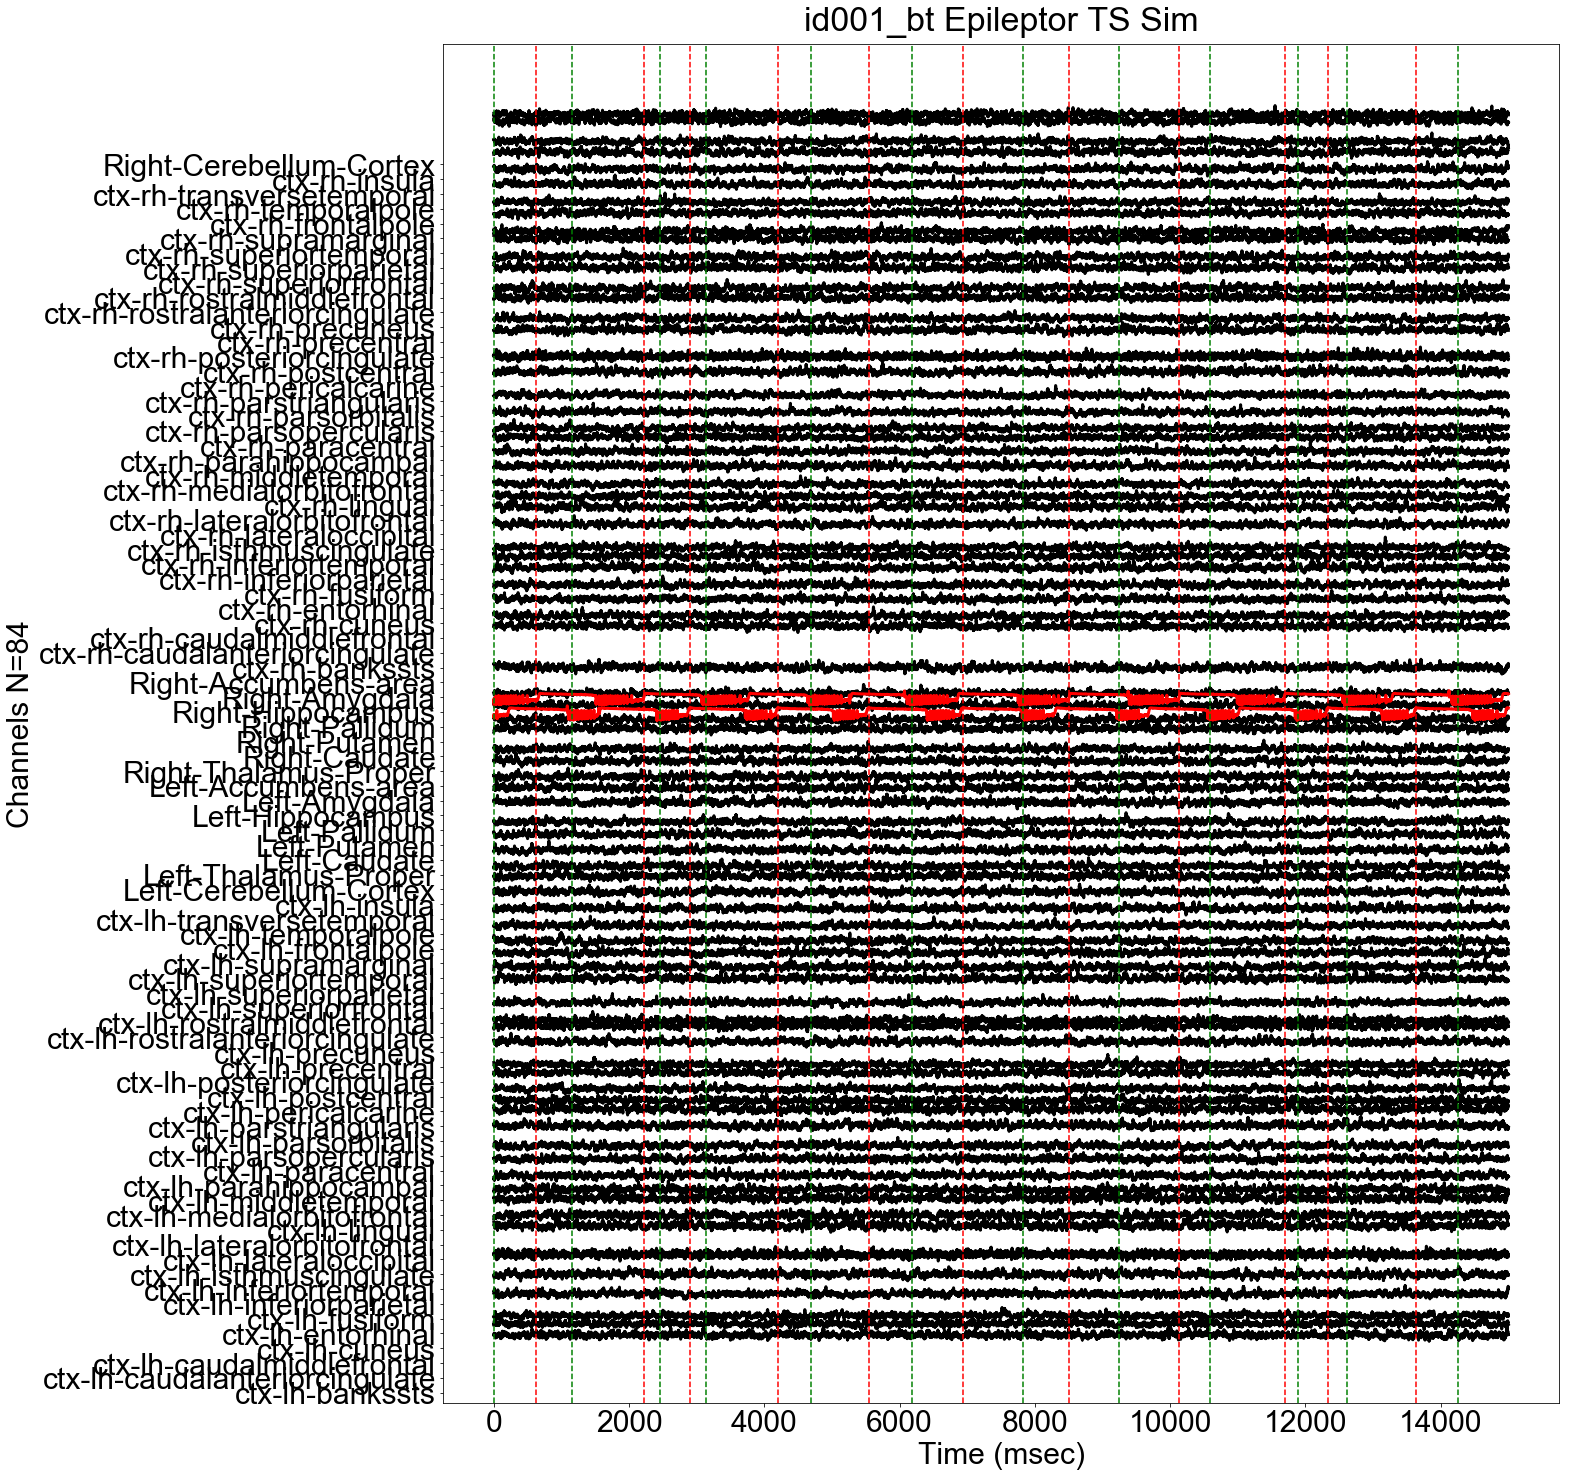

In [77]:
tsviz = tvbsim.visualize.old.plotts.VisualTs()
tsviz.loaddata(data=epits,ylabels=conn.region_labels)
tsviz.setfigsize(figsize=(20,25))
fig, ax = tsviz.plotts(normalize=True, titlestr='{} Epileptor TS Sim'.format(patient))
tsviz.plotvertlines(onsettimes=seizonsets, offsettimes=seizoffsets)
tsviz.colorts(modelezinds, color='red')
tsviz.colorts(modelpzinds, color='blue')

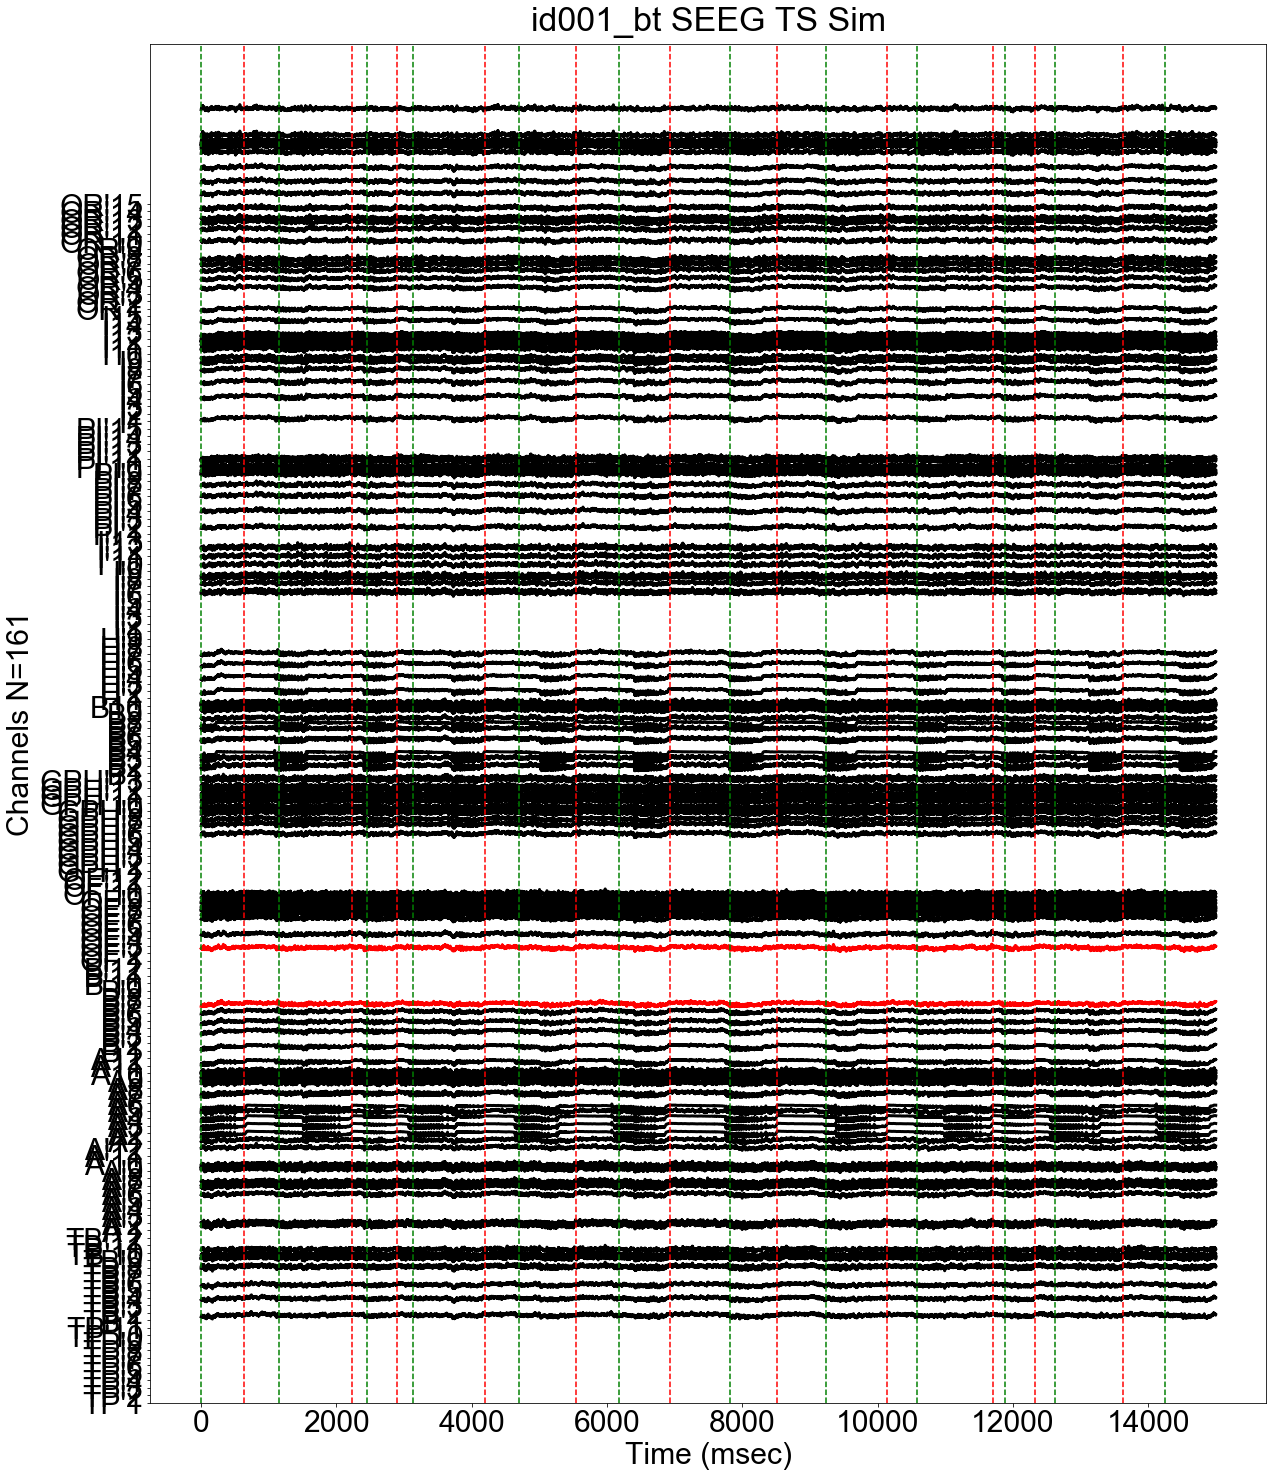

In [78]:
tsviz = tvbsim.visualize.old.plotts.VisualTs()
tsviz.loaddata(data=seegts,ylabels=loader.chanxyzlabels)
tsviz.setfigsize(figsize=(20,25))
fig, ax = tsviz.plotts(normalize=True, titlestr='{} SEEG TS Sim'.format(patient))
tsviz.plotvertlines(onsettimes=seizonsets, offsettimes=seizoffsets)
tsviz.colorts(modelezinds, color='red')
tsviz.colorts(modelpzinds, color='blue')

# Frequency Analysis

In [7]:
def load_raw_data(patdatadir, datafile, metadatadir, patient, reference):
    loader = LoadSimDataset(root_dir=patdatadir, 
                                datafile=datafile, 
                                rawdatadir=metadatadir, 
                                patient=patient,
                                reference=reference, 
                                preload=True)
    # get filtered/referenced rawdata
    epits = loader.epits
    rawdata = loader.rawdata 
    metadata = loader.getmetadata()

    return epits, rawdata, metadata

# load in the data to run frequency analysis
reference = 'monopolar'
patdatadir = outputdatadir
metadatadir = root_dir
datafile = outputfilename
epits, rawdata, metadata = load_raw_data(patdatadir, datafile, metadatadir, patient, reference)

2018-06-20 16:11:47,254 - DEBUG - LoadSimDataset - Reading in metadata!
2018-06-20 16:11:47,257 - DEBUG - LoadSimDataset - 
Already renamed seeg.xyz possibly!

2018-06-20 16:11:47,263 - DEBUG - LoadSimDataset - 
Loaded in seeg xyz coords!

2018-06-20 16:11:52,483 - DEBUG - LoadSimDataset - 
Mapped contacts to regions!

2018-06-20 16:11:52,490 - INFO - LoadSimDataset - 
Loaded in ez hypothesis!

   INFO  
Loaded in ez hypothesis!

2018-06-20 16:11:52,493 - INFO - tvbsim.io.readers.read_connectivity - Starting to read a Connectivity from: /Users/adam2392/Downloads/tngpipeline/id001_bt/tvb/connectivity.zip
   INFO  Starting to read a Connectivity from: /Users/adam2392/Downloads/tngpipeline/id001_bt/tvb/connectivity.zip
2018-06-20 16:11:52,513 - INFO - tvbsim.io.readers.read_connectivity - Successfully read connectvity from: /Users/adam2392/Downloads/tngpipeline/id001_bt/tvb/connectivity.zip
   INFO  Successfully read connectvity from: /Users/adam2392/Downloads/tngpipeline/id001_bt/tvb/con

# Determine Frequency Content In Alpha, Beta, Gamma, High Bands

In [35]:
def binfreqvalues(power, freqs, freqbands):
    # Create an empty array
    power_binned = np.zeros(shape=(power.shape[0],
                                   len(freqbands),
                                   power.shape[2]))
    
    for idx, (name, freqband) in enumerate(sorted(freqbands.items())):
        print(name, freqband)
        # compute the freq indices for each band
        freqbandindices = _computefreqindices(freqs, freqband)
        
        # Create an empty array = C x T (frequency axis is compresssed into 1 band)
        # average between these two indices
        power_binned[:, idx, :] = np.mean(
            power[:, freqbandindices[0]:freqbandindices[1] + 1, :], axis=1)
    return power_binned
def _computefreqindices(reqs, freqband):
        """
        Compute the frequency indices for this frequency band

        freqs = list of frequencies
        freqband = [lowerbound, upperbound] frequencies of the 
                frequency band
        """
        for freq in freqband:
            lowerband = freqband[0]
            upperband = freqband[1]

            # get indices where the freq bands are put in
            freqbandindices = np.where(
                (freqs >= lowerband) & (freqs < upperband))
            freqbandindices = [freqbandindices[0][0], freqbandindices[0][-1]]
        return freqbandindices

Number of frequencies: 251
Number of time steps: 60
500
250
(137, 251, 60)
2.885901611968964
-4.733880002994565
CPU times: user 786 ms, sys: 59.8 ms, total: 845 ms
Wall time: 849 ms


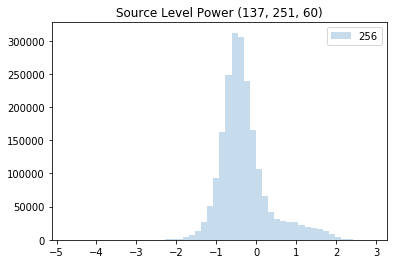

In [42]:
%%time
winsize = 500
stepsize = 250
samplerate = 256

power = mne.time_frequency.stft(rawdata, wsize=winsize, tstep=stepsize)
freqs = mne.time_frequency.stftfreq(wsize=winsize, sfreq=samplerate)
power = np.log10(np.abs(power))
print(winsize)
print(stepsize)
print(power.shape)

plt.figure()
ax = sns.distplot(power.ravel(), kde=False, hist_kws={'alpha':0.25}, label=str(samplerate))
ax.set_title('Source Level Power {}'.format(power.shape))
ax.legend()

print(max(power.ravel()))
print(min(power.ravel()))

In [43]:
freqbands = {
    'alpha': [0, 15],
    'beta': [15,30],
    'gamma': [30, 90],
    'high': [90, samplerate//2],
}
power_binned = binfreqvalues(power, freqs, freqbands)

print(power_binned.shape)

('alpha', [0, 15])
('beta', [15, 30])
('gamma', [30, 90])
('high', [90, 128])
(137, 4, 60)


alpha
beta
gamma
high


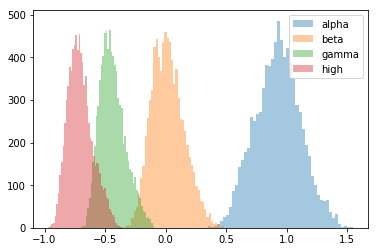

In [44]:
plt.figure()
for i in range(len(freqbands)):
    label = sorted(freqbands.keys())[i]
    print(label)
    sns.distplot(power_binned[:,i,:].ravel(), kde=False, label=label)
plt.legend()

alpha
beta
gamma
high


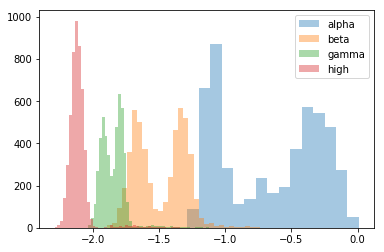

In [40]:
plt.figure()
for i in range(len(freqbands)):
    label = sorted(freqbands.keys())[i]
    print(label)
    sns.distplot(power_binned[:,i,:].ravel(), kde=False, label=label)
plt.legend()

# Get Power Spectral Density Of Entire Time Series

Looks at each time series, and computes the power spectrum density of that window. This will give you an idea of the power distribution acorss each time series.

In [10]:
import mne
from mne import create_info, EpochsArray
mtbandwidth=4
freqs = np.arange(1., 500., 5.)
n_cycles = freqs / 2.
samplerate = 1000
fmin = 1
fmax = 500

winsize = 500
stepsize = 250

vmin, vmax = -3., 3.  # Define our color limits.

chanlabels = list(metadata['chanlabels'])
reglabels = list(metadata['region_labels'])


    using multitaper spectrum estimation with 58 DPSS windows
(84, 7486)
(7486,)
422.8469114070498
0.00010909709353880233
Effective window size : 0.256 (s)
(84, 128)
(128,)
0.024327563810448365
1.1120161995493458e-07


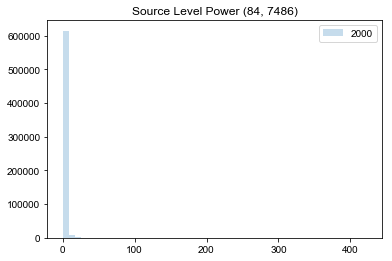

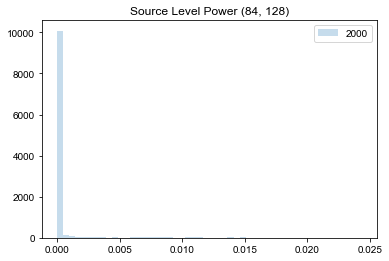

In [86]:
power, freqs = mne.time_frequency.psd_array_multitaper(epits, sfreq=samplerate, 
                                                    fmin=fmin, fmax=fmax,
                                                    bandwidth=mtbandwidth)
print(power.shape)
print(freqs.shape)
plt.figure()
ax = sns.distplot(power.ravel(), kde=False, 
                  hist_kws={'alpha':0.25}, label=str(srate))
ax.set_title('Source Level Power {}'.format(power.shape))
# ax.set_xticks(freqs)
# ax.set_xticklabels(freqs)
ax.legend()
print(max(power.ravel()))
print(min(power.ravel()))

################# compute using welch's method
power, freqs = mne.time_frequency.psd_array_welch(epits, sfreq=samplerate, 
                                                    fmin=fmin, fmax=fmax)
print(power.shape)
print(freqs.shape)

plt.figure()
ax = sns.distplot(power.ravel(), kde=False, hist_kws={'alpha':0.25}, label=str(srate))
ax.set_title('Source Level Power {}'.format(power.shape))
ax.legend()

print(max(power.ravel()))
print(min(power.ravel()))

(1, 84, 100, 15000)
(100,)
1.1979536784588978
-5.863684247347763
CPU times: user 1min 1s, sys: 4.4 s, total: 1min 6s
Wall time: 1min 7s


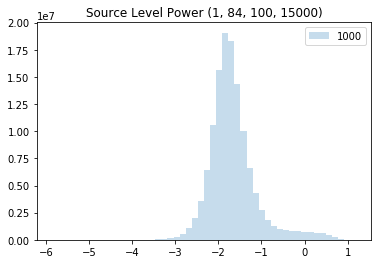

In [11]:
%%time

power = mne.time_frequency.tfr_array_multitaper(epits[np.newaxis,...], 
                                                       sfreq=samplerate, 
                                                       freqs=freqs, 
                                                     n_cycles=n_cycles)
power = np.log10(np.abs(power))
print(power.shape)
print(freqs.shape)

plt.figure()
ax = sns.distplot(power.ravel(), kde=False, hist_kws={'alpha':0.25}, label=str(samplerate))
ax.set_title('Source Level Power {}'.format(power.shape))
ax.legend()

print(max(power.ravel()))
print(min(power.ravel()))

Number of frequencies: 251
Number of time steps: 60
500
250
(84, 251, 60)
1.29054265848593
-5.755583683283845
CPU times: user 428 ms, sys: 69.7 ms, total: 497 ms
Wall time: 496 ms


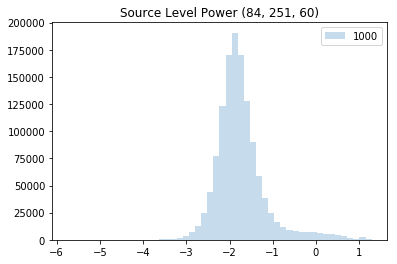

In [12]:
%%time

power = mne.time_frequency.stft(epits, wsize=winsize, tstep=stepsize)
power = np.log10(np.abs(power))
print(winsize)
print(stepsize)
print(power.shape)

plt.figure()
ax = sns.distplot(power.ravel(), kde=False, hist_kws={'alpha':0.25}, label=str(samplerate))
ax.set_title('Source Level Power {}'.format(power.shape))
ax.legend()

print(max(power.ravel()))
print(min(power.ravel()))

500
250
(1, 84, 100, 15000)
1.2090698159996638
-6.256731715691689
CPU times: user 52.8 s, sys: 3.29 s, total: 56.1 s
Wall time: 56.2 s


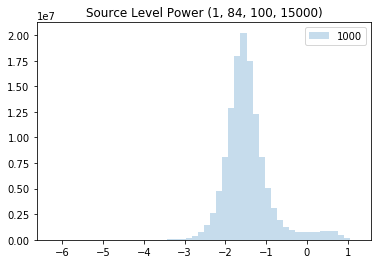

In [13]:
%%time
power = mne.time_frequency.tfr_array_morlet(epits[np.newaxis,...], 
                                            sfreq=samplerate, 
                                           freqs=freqs)

power = np.log10(np.abs(power))
print(winsize)
print(stepsize)
print(power.shape)

plt.figure()
ax = sns.distplot(power.ravel(), kde=False, hist_kws={'alpha':0.25}, label=str(samplerate))
ax.set_title('Source Level Power {}'.format(power.shape))
ax.legend()

print(max(power.ravel()))
print(min(power.ravel()))

# Looping Over Sample Rates

(1, 84, 100, 15000)
(100,)
1.0256105067374726
-6.339033704103921
(1, 84, 100, 15000)
(100,)
1.0423893038624394
-7.933017345016619
(1, 84, 100, 15000)
(100,)
1.1979536784588978
-5.863684247347763
(1, 84, 100, 15000)
(100,)
1.3385607847494316
-5.420726341882009


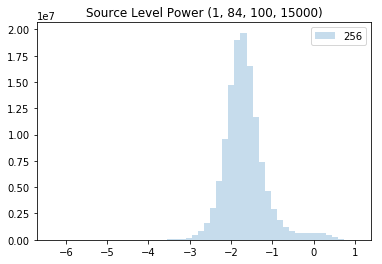

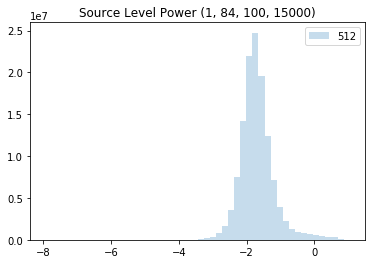

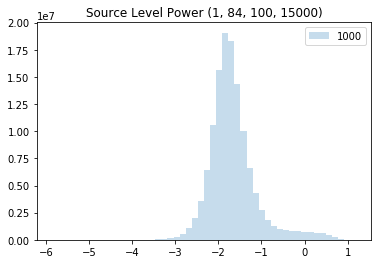

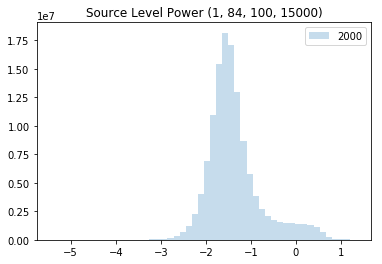

In [19]:
for srate in [256, 512, 1000, 2000]:
    power = mne.time_frequency.tfr_array_multitaper(epits[np.newaxis,...], 
                                                           sfreq=srate, 
                                                           freqs=freqs, 
                                                         n_cycles=n_cycles)
    power = np.log10(np.abs(power))
    print(power.shape)
    print(freqs.shape)

    plt.figure()
    ax = sns.distplot(power.ravel(), kde=False, hist_kws={'alpha':0.25}, label=str(srate))
    ax.set_title('Source Level Power {}'.format(power.shape))
    ax.legend()

    print(max(power.ravel()))
    print(min(power.ravel()))

In [21]:
# %%time
# power, _freqs = mne.time_frequency.tfr_array_stockwell(epits[np.newaxis,:,0:5000], 
#                                             sfreq=samplerate, 
#                                            fmin=fmin,
#                                             fmax=fmax)

# power = np.log10(np.abs(power))
# print(winsize)
# print(stepsize)
# print(power.shape)

# plt.figure()
# ax = sns.distplot(power.ravel(), kde=False, hist_kws={'alpha':0.25}, label=str(samplerate))
# ax.set_title('Source Level Power {}'.format(power.shape))
# ax.legend()

# print(max(power.ravel()))
# print(min(power.ravel()))

In [14]:
# Wavelet Parameters
waveletfreqs = 2**(np.arange(1.,9.,1./5))
waveletwidth = 6 # None
wavelets = mne.time_frequency.morlet(sfreq=samplerate, freqs=waveletfreqs, sigma=waveletwidth)

print(np.array(wavelets).shape)

(40, 1857)


# Using the Old Functions I Implemented By Hand

['ez_region', 'reference', 'onsetsec', 'timepoints', 'sim_ez_reg', 'region_labels', 'samplerate', 'chanlabels', 'sim_x0_pz', 'sim_x0_norm', 'sim_x0_ez', 'contact_regs', 'onsetind', 'chanxyz', 'patient', 'offsetsec', 'offsetind', 'stepsize', 'linefreq', 'sim_pz_reg', 'freqs', 'winsize', 'allchans', 'record_date', 'lowpass_freq', 'mtbandwidth', 'rawfilename', 'highpass_freq']
2018-06-19 18:57:42,335 - INFO - MorletWavelet - Loaded raw data in Morlet Transform!
   INFO  Loaded raw data in Morlet Transform!
(84, 40, 15000)
(84, 40, 15000)
(84, 40, 15000)
(84, 40, 15000)
['ez_region', 'reference', 'onsetsec', 'timepoints', 'sim_ez_reg', 'region_labels', 'samplerate', 'chanlabels', 'sim_x0_pz', 'sim_x0_norm', 'waveletwidth', 'sim_x0_ez', 'contact_regs', 'onsetind', 'chanxyz', 'patient', 'offsetsec', 'offsetind', 'stepsize', 'linefreq', 'sim_pz_reg', 'freqs', 'winsize', 'allchans', 'record_date', 'lowpass_freq', 'mtbandwidth', 'rawfilename', 'highpass_freq']
['ez_region', 'reference', 'onsets

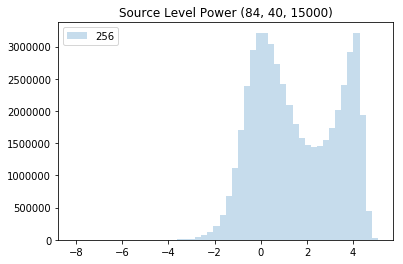

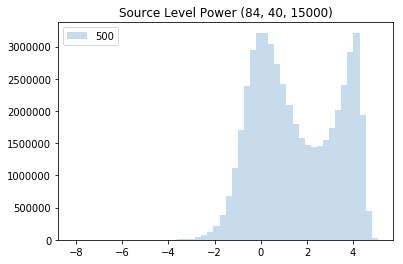

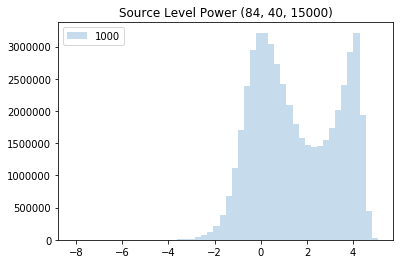

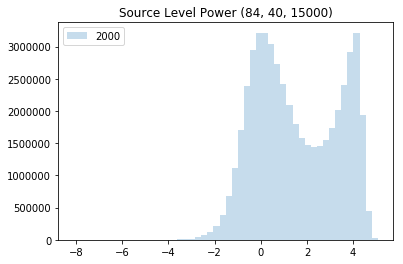

In [18]:
winsize = 500
stepsize = 250
metadata['winsize'] = winsize
metadata['stepsize'] = stepsize


for srate in [256, 500, 1000, 2000]:
    mode = 'morlet'        
    # create checker for num wins
    freqoutputdir = os.path.join(outputdatadir, 'freq', mode, patient)
    if not os.path.exists(freqoutputdir):
        os.makedirs(freqoutputdir)
    # where to save final computation
    outputfilename_source = os.path.join(freqoutputdir, 
            '{}_{}_{}model_epi.npz'.format(patient, mode, i))
    outputmetafilename_source = os.path.join(freqoutputdir,
        '{}_{}_{}meta_epi.json'.format(patient, mode, i))
    power, phase, metadata = run_freq(epits, metadata, mode, samplerate=srate)

    print(power.shape)
    print(phase.shape)
    print(metadata.keys())
    
    plt.figure()
    ax = sns.distplot(power.ravel(), kde=False, hist_kws={'alpha':0.25}, label=str(srate))
    ax.set_title('Source Level Power {}'.format(power.shape))
    ax.legend()

In [36]:
mode = 'fft'
# create checker for num wins
freqoutputdir = os.path.join(outputdatadir, 'freq', mode, patient)
if not os.path.exists(freqoutputdir):
    os.makedirs(freqoutputdir)
# where to save final computation
outputfilename_seeg = os.path.join(freqoutputdir, 
        '{}_{}_{}model.npz'.format(patient, mode, i))
outputmetafilename_seeg = os.path.join(freqoutputdir,
    '{}_{}_{}meta.json'.format(patient, mode, i))
power, phase, metadata = run_freq(rawdata, metadata, mode)

print(power.shape)
print(phase.shape)
print(metadata.keys())

plt.figure()
ax = sns.distplot(power.ravel(), kde=False, kde_kws={'alpha':0.25})
ax.set_title('SEEG Level Power {}'.format(power.shape))

['ez_region', 'reference', 'onsetsec', 'timepoints', 'sim_ez_reg', 'region_labels', 'samplerate', 'chanlabels', 'sim_x0_pz', 'sim_x0_norm', 'sim_x0_ez', 'contact_regs', 'onsetind', 'chanxyz', 'patient', 'offsetsec', 'offsetind', 'stepsize', 'linefreq', 'sim_pz_reg', 'freqs', 'winsize', 'allchans', 'record_date', 'lowpass_freq', 'mtbandwidth', 'rawfilename', 'highpass_freq']
2018-06-19 16:24:45,673 - INFO - MultiTaperFFT - Default method of tapering is eigen
2018-06-19 16:24:45,673 - INFO - MultiTaperFFT - Default method of tapering is eigen
2018-06-19 16:24:45,673 - INFO - MultiTaperFFT - Default method of tapering is eigen
   INFO  Default method of tapering is eigen
2018-06-19 16:24:45,679 - INFO - MultiTaperFFT - Loaded raw data in MultiTaperFFT!
2018-06-19 16:24:45,679 - INFO - MultiTaperFFT - Loaded raw data in MultiTaperFFT!
2018-06-19 16:24:45,679 - INFO - MultiTaperFFT - Loaded raw data in MultiTaperFFT!
   INFO  Loaded raw data in MultiTaperFFT!
(137, 251, 59)
(137, 251, 59)
[